### Limpesa dos dados é chata, mas nescessária
Podemos utilizar métodos estatísticos para identificar observações que parecem raras ou improváveis, dados os dados disponíveis. Isso não significa que os valores identificados sejam discrepantes e devam ser removidos. Uma boa dica é considerar traçar os valores discrepantes identificados, talvez no contexto de valores não discrepantes, para ver se há alguma relação ou padrão sistemático com os valores discrepantes

#### Let's start by importing all the required libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option("display.max_columns",None) 
pd.set_option("display.max_rows",None) 

import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
sns.set(style="darkgrid", palette="pastel", color_codes=True)
sns.set_context('talk')

from pathlib import Path
data_dir = Path('../input/images')

# O que são outliers?

#### Vou tentar explicar de forma simplificada
### Um outlier é uma observação diferente das outras observações. É raro, ou distinto, ou não se ajusta de alguma forma. Também é chamada de anomalia.

Tipos de Outliers:
Outlier pode ser de dois tipos:¶
1) Univariada
2) Multivariada.
   
Outliers  `univariados` podem ser encontrados quando observamos a distribuição de uma única variável. 
Outliers `multivariados` são outliers em um espaço n-dimensional.Para encontrá-los, é necessário observar as distribuições em multidimensões.

Vamos entender isso com um exemplo. 
Digamos que estamos entendendo a relação entre altura e peso.
Abaixo, temos distribuição univariada e bivariada para Altura, Peso. 
Dê uma olhada no gráfico da caixa.
Não temos nenhum outlier (acima e abaixo de 1,5*IQR, método mais comum). 

Agora observe o gráfico de dispersão. Aqui, temos dois valores abaixo e um acima da média em um segmento específico de peso e altura.

<img src="https://media.giphy.com/media/bWlBE4EgQrXb2/giphy.gif">

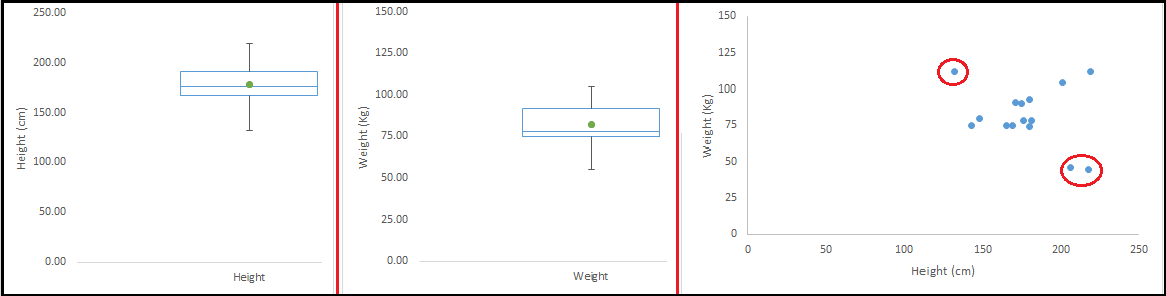

In [3]:
Image(filename=data_dir/'O5.png')

Qual é o impacto dos Outliers em um conjunto de dados?

Valores discrepantes podem alterar drasticamente os resultados da análise de dados e da modelagem estatística. 
Existem vários impactos desfavoráveis ​​de outliers no conjunto de dados:

- Aumenta a variância do erro e reduz o poder dos testes estatísticos
- Se os outliers forem distribuídos de forma não aleatória, eles podem diminuir a normalidade
- Podem distorcer ou influenciar estimativas que podem ser de interesse substantivo
- Eles também podem impactar a suposição básica de Regressão, ANOVA e outras suposições do modelo estatístico.
Para entender profundamente o impacto, vamos dar um exemplo para verificar o que acontece com um conjunto de dados com e sem valores discrepantes no conjunto de dados.¶

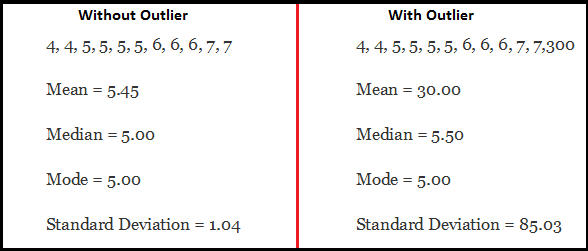

In [4]:
Image(filename=data_dir/'O6.png')

#### Como você pode ver, o conjunto de dados com valores discrepantes tem média e desvio padrão significativamente diferentes. No primeiro cenário, diremos que a média é 5,45. Mas com o valor atípico, a média sobe para 30. Isto mudaria completamente a estimativa.¶

### Further to give examples on outlier detection and remidial measures, I'll take up a few datasets to work on

# Técnicas de detecção de outliers:

## A) Univariate Outliers:

In [10]:
df_1 = pd.read_csv("dados/heart.csv")
df_1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


#### Realizarei EDA básico para analisar o Data Frame

In [11]:
df_1.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

#### Não há valores nulos

In [12]:
df_1.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


#### Vamos considerar o colesterol sérico na coluna mg/dl, ou seja, "chol" para nossa análise. Vou traçar um gráfico de caixa simples que é a melhor visualização para detectar valores discrepantes

<Axes: ylabel='chol'>

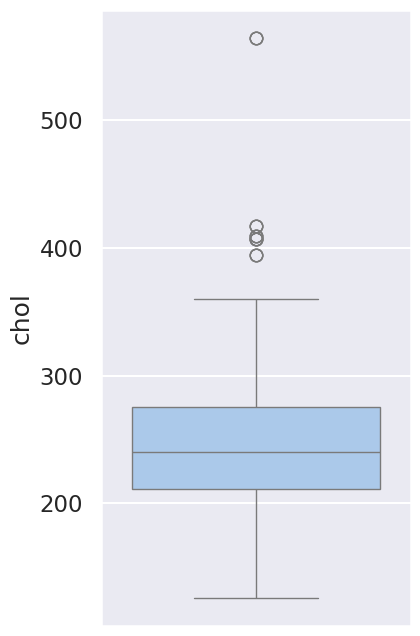

In [13]:
plt.figure(figsize = (4,8))
sns.boxplot(y = df_1.chol)

#### A partir do gráfico de caixa acima, podemos certamente observar que existem valores discrepantes nele!!

# 1) Método do Intervalo Interquartil 

#### O conceito de Intervalo Interquartil (IQR) é utilizado para construir os gráficos boxplot. IQR é um conceito em estatística usado para medir a dispersão estatística e a variabilidade dos dados, dividindo o conjunto de dados em quartis.

#### Em palavras simples, qualquer conjunto de dados ou qualquer conjunto de observações é dividido em quatro intervalos definidos com base nos valores dos dados e em como eles se comparam a todo o conjunto de dados. Um quartil é o que divide os dados em três pontos e quatro intervalos

####  É a diferença entre o terceiro quartil e o primeiro quartil (IQR = Q3 -Q1). Outliers, neste caso, são definidos como as observações que estão abaixo (Q1 - 1,5x IQR) ou boxplot do bigode inferior ou acima (Q3 + 1,5x IQR) ou boxplot do bigode superior.

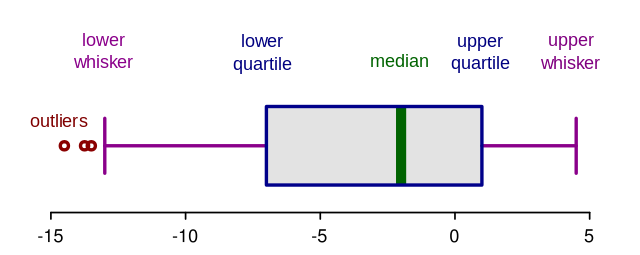

In [9]:
Image(filename=data_dir/'O3.png')

#### Vamos definir uma função para descobrir o IQR, bigode inferior e superior..

In [16]:
def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    
    #calculando IQR
    iqr = q75 - q25
    #Ponto de corte
    cut_off = iqr * 1.5
    
    
    lower, upper = q25 - cut_off, q75 + cut_off
    
    print('O IQR é : ',iqr)
    print('O limite inferior é : ', lower)
    print('O limete superior é : ', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('O total de outlier detectados : ', df1.shape[0]+ df2.shape[0])

### Como exemplo, usarei o conjunto de dados UCI de doenças cardíacas para explicar o método IQR. [Heart disease UCI DataSet](https://www.kaggle.com/ronitf/heart-disease-uci) 

In [17]:
out_iqr(df_1,'chol')
#Input the dataset and the required column

O IQR é :  64.0
O limite inferior é :  115.0
O limete superior é :  371.0
O total de outlier detectados :  16


### Visual representation:

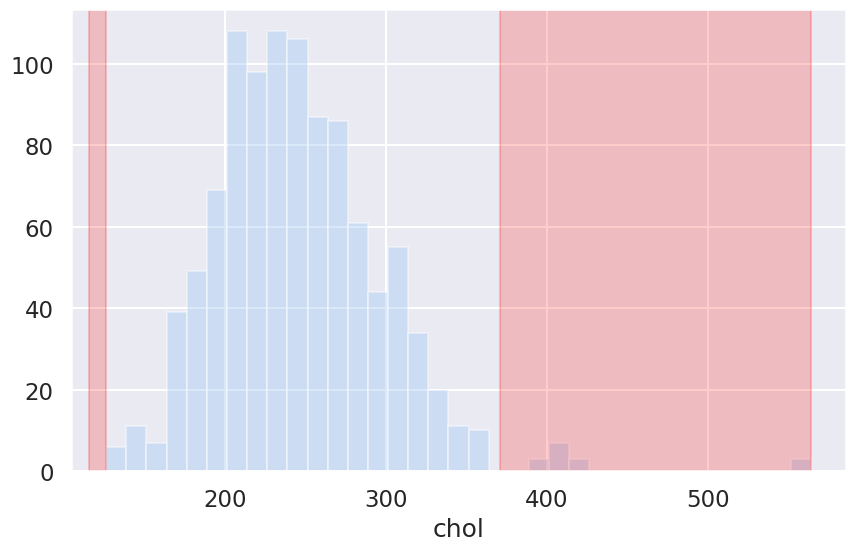

In [18]:
plt.figure(figsize = (10,6))
sns.distplot(df_1.chol, kde=False)
plt.axvspan(xmin = lower,xmax= df_1.chol.min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df_1.chol.max(),alpha=0.2, color='red')

#### Aqui a zona vermelha representa a zona outlier! Os registros presentes nessa zona são considerados outliers

### Medida Corretiva:
#### Remova os registros que estão acima do valor do limite superior e os registros abaixo do valor do limite inferior!

In [19]:
#Data Frame without outliers
df_new = df_1[(df_1['chol'] < upper) | (df_1['chol'] > lower)]

In [20]:
df_new

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
7,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
8,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
9,54,1,0,122,286,0,0,116,1,3.2,1,2,2,0


# 2) Método de Desvio Padrão

#### O desvio padrão é uma métrica de variância, ou seja, quanto os pontos de dados individuais estão espalhados em relação à média. Nas estatísticas, se uma distribuição de dados for aproximadamente normal, então cerca de 68% dos valores dos dados estão dentro de um desvio padrão da média e cerca de 95% estão dentro de dois desvios padrão, e cerca de 99,7% estão dentro de três desvios padrão.

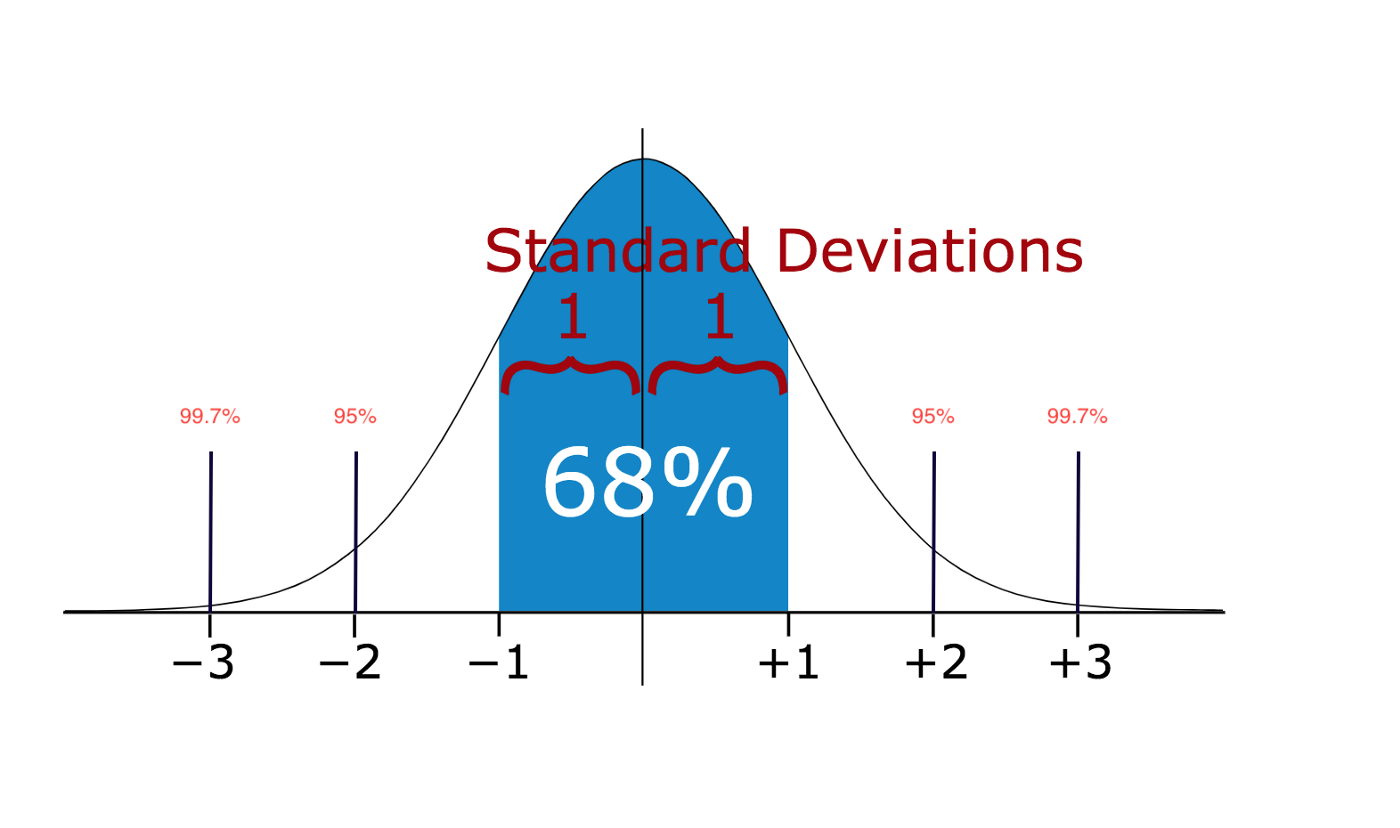

In [14]:
Image(filename=data_dir/'O4.png')

####  Por exemplo, abordarei Desempenho do aluno no conjunto de dados do exame [Student Performance in Exam DataSet](https://www.kaggle.com/spscientist/students-performance-in-exams) 

In [21]:
df_2 = pd.read_csv("dados/StudentsPerformance.csv")
df_2.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#### Vamos considerar a `writing score` para inspeção. Vou traçar um gráfico de densidade simples, que também é uma das melhores visualizações para detectar valores discrepantes

<Axes: xlabel='writing score', ylabel='Density'>

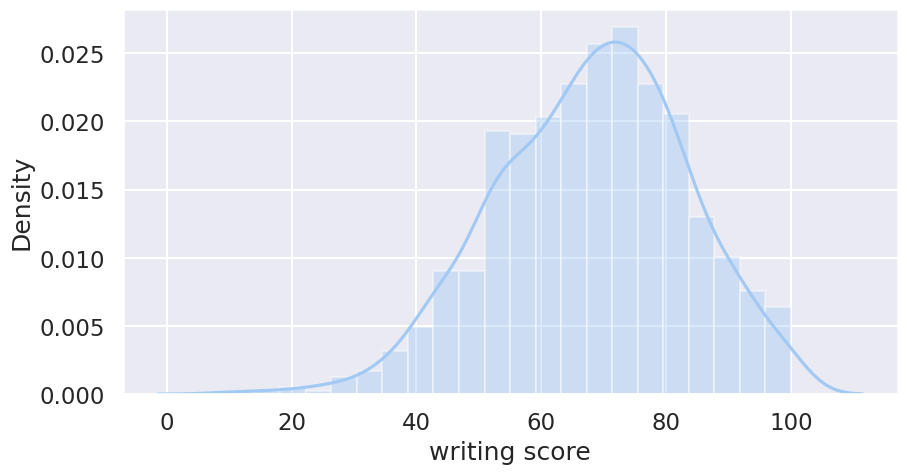

In [22]:
plt.figure(figsize = (10,5))
sns.distplot(df_2['writing score'])

#### By the looks of it, it is left tailed and it surely has outliers.

#### Let's define a function to find out the lower and the upper whisker using SDM:

In [25]:
def out_std(df, column):
    global lower,upper
    # calcular a média e o desvio padrão do quadro de dados
    data_mean, data_std = df[column].mean(), df[column].std()
    # Calulando o ponto do corte
    cut_off = data_std * 3
    # calcular o valor do limite inferior e superior
    lower, upper = data_mean - cut_off, data_mean + cut_off
    print('Limite inferior: ', lower)
    print('Limite superior: ', upper)
    # Calcule o número de registros abaixo e acima do valor limite inferior e acima, respectivamente
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total de outliers é ', df1.shape[0]+ df2.shape[0])

In [26]:
out_std(df_2,'writing score')

Limite inferior:  22.46702896739105
Limite superior:  113.64097103260895
Total de outliers é  4


### Visual Representation:

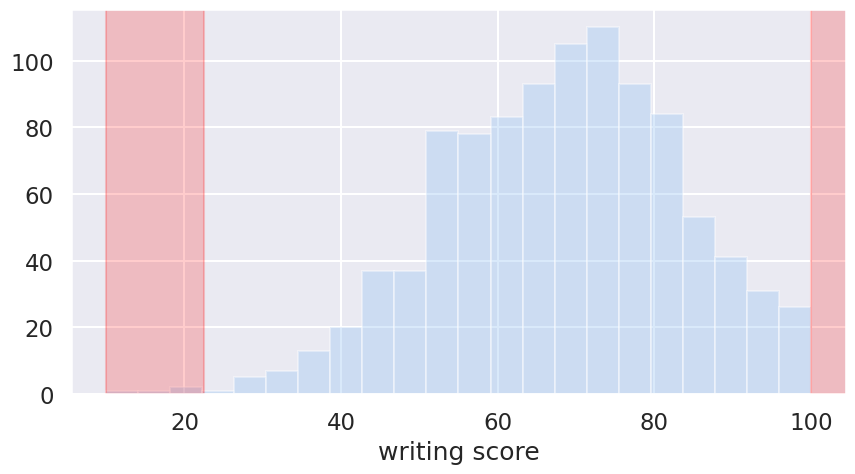

In [27]:
plt.figure(figsize = (10,5))
sns.distplot(df_2['writing score'], kde=False)
plt.axvspan(xmin = lower,xmax= df_2['writing score'].min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df_2['writing score'].max(),alpha=0.2, color='red')

#### Aqui a zona vermelha representa a zona outlier! Os registros presentes nessa zona são considerados outliers

### Corrigindo:
#### Removendo os outliers

In [28]:
#Data Frame sem outliers
df_new = df_2[(df_2['writing score'] < upper) | (df_2['writing score'] > lower)]

# 3) Método Z-Score:

#### O escore Z é o número sinalizado de desvios padrão pelos quais o valor de uma observação ou ponto de dados está acima do valor médio do que está sendo observado ou medido.

#### A intuição por trás do escore Z é descrever qualquer ponto de dados, encontrando sua relação com o desvio padrão e a média do grupo de pontos de dados. O escore Z é encontrar a distribuição dos dados onde a média é 0 e o desvio padrão é 1, ou seja, distribuição normal.

#### Você deve estar se perguntando: como isso ajuda a identificar os valores discrepantes? Bem, ao calcular a pontuação Z, redimensionamos e centralizamos os dados e procuramos pontos de dados que estão muito longe de zero. Esses pontos de dados que estão muito longe de zero serão tratados como valores discrepantes. Na maioria dos casos, um limite de 3 ou -3 é usado, ou seja, se o valor do escore Z for maior ou menor que 3 ou -3, respectivamente, esse ponto de dados será identificado como discrepante.

#### Esta técnica assume uma distribuição gaussiana dos dados. Os outliers são os pontos de dados que estão nas caudas da distribuição e, portanto, longe da média. Até que ponto depende de um limite definido zthr para os pontos de dados normalizados zi calculados com a fórmula: 

###                      Z_score= (Xi - media) / standard deviation 

#### onde Xi é um ponto de dados, 'média' é a média de todos os X e 'desvio padrão' é o desvio padrão de todos os X.

#### AUm outlier é então um ponto de dados normalizado que possui um valor absoluto maior que Zthr. Aquilo é: 

###                                     |Z_score| > Zthr

#### Os valores Zthr comumente usados ​​são 2,5, 3,0 e 3,5. Aqui usaremos 3.0

#### or exemplo, abordarei os conjuntos de dados pessoais de custo TMedical [TMedical Cost Personal Datasets](https://www.kaggle.com/mirichoi0218/insurance) para explicar o método Z-Score.

In [30]:
df_3 = pd.read_csv("dados/insurance.csv")
df_3.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Vamos realizar EDA básico para analisar o conjunto de dados

In [31]:
df_3.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [23]:
df_3.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### Consideremos as `charges` para analise. Vou traçar um gráfico de densidade simples que é uma das melhores visualizações para detectar valores discrepantes

<Axes: xlabel='charges', ylabel='Density'>

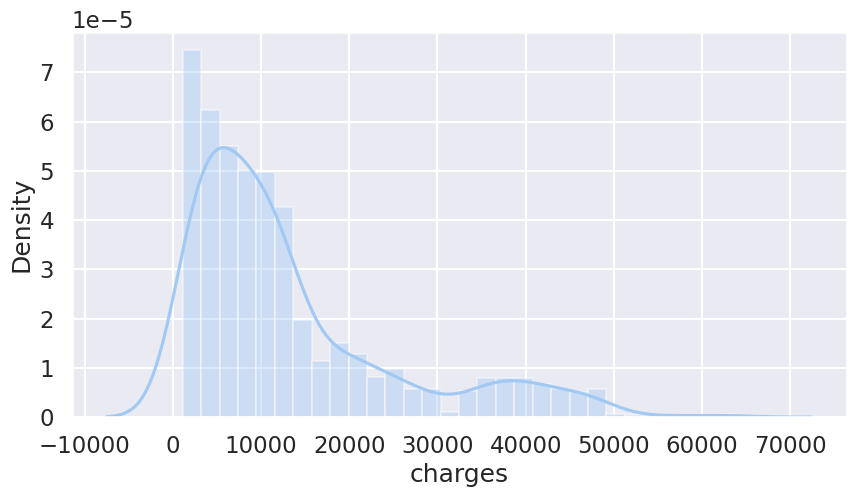

In [32]:
plt.figure(figsize = (10,5))
sns.distplot(df_3['charges'])

#### By the looks of it, it is right tailed and it surely has outliers.

#### Let's define a function to find out the lower and the upper whisker using Z-Score method:

In [33]:
def out_zscore(data):
    global outliers,zscore
    outliers = []
    zscore = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score= (i - mean)/std 
        zscore.append(z_score)
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return print("Total de outliers",len(outliers))

In [34]:
out_zscore(df_3.charges)

Total de outliers 7


### Visualização

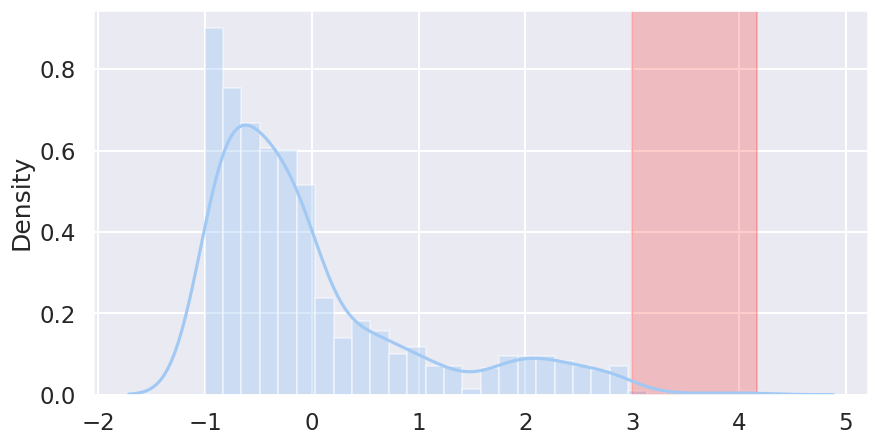

In [35]:
plt.figure(figsize = (10,5))
sns.distplot(zscore)
plt.axvspan(xmin = 3 ,xmax= max(zscore),alpha=0.2, color='red')

#### Aqui a zona vermelha representa a zona atípica! Os registros presentes nessa zona são considerados outliers

### Removendos os outliers:


In [36]:
#Data Frame without outliers
df_new = df_3[(df_3['charges'] < 3) | (df_3['charges'] > -3)]

### Let's move to some advanced methods of outlier detection 

# 4) Isolation Forest

#### Floresta de isolamento é um algoritmo para detectar valores discrepantes. Ele particiona os dados usando um conjunto de árvores e fornece uma pontuação de anomalia observando o quão isolado o ponto está na estrutura encontrada. A pontuação de anomalia é então usada para diferenciar valores discrepantes de observações normais. 

#### Um conceito importante neste método é o número de isolamento. O número de isolamento é o número de divisões necessárias para isolar um ponto de dados. Este número de divisões é determinado seguindo estas etapas:

#### - Um ponto “a” para isolar é selecionado aleatoriamente.
#### - É selecionado um ponto de dados aleatório “b” que esteja entre o valor mínimo e máximo e diferente de “a”.
#### - Se o valor de “b” for inferior ao valor de “a”, o valor de “b” passa a ser o novo limite inferior
#### - Se o valor de “b” for maior que o valor de “a”, o valor de “b” passa a ser o novo limite superior.
#### - Este procedimento é repetido enquanto houver pontos de dados diferentes de “a” entre o limite superior e o inferior.

#### São necessárias menos divisões para isolar um valor discrepante do que para isolar um ponto não discrepante, ou seja, um valor discrepante tem um número de isolamento menor em comparação com um ponto não discrepante. Um ponto de dados é, portanto, definido como um valor discrepante se o seu número de isolamento for inferior ao limite. O limite é definido com base na porcentagem estimada de valores discrepantes nos dados, que é o ponto de partida deste algoritmo de detecção de valores discrepantes. 

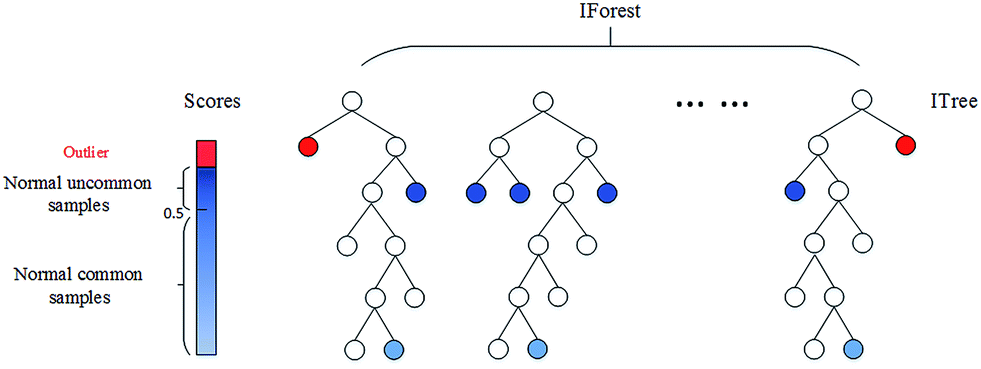

In [29]:
Image(filename=data_dir/'O8.png')

#### Vamos considerar o conjunto de dados de desempenho dos alunos para análise.

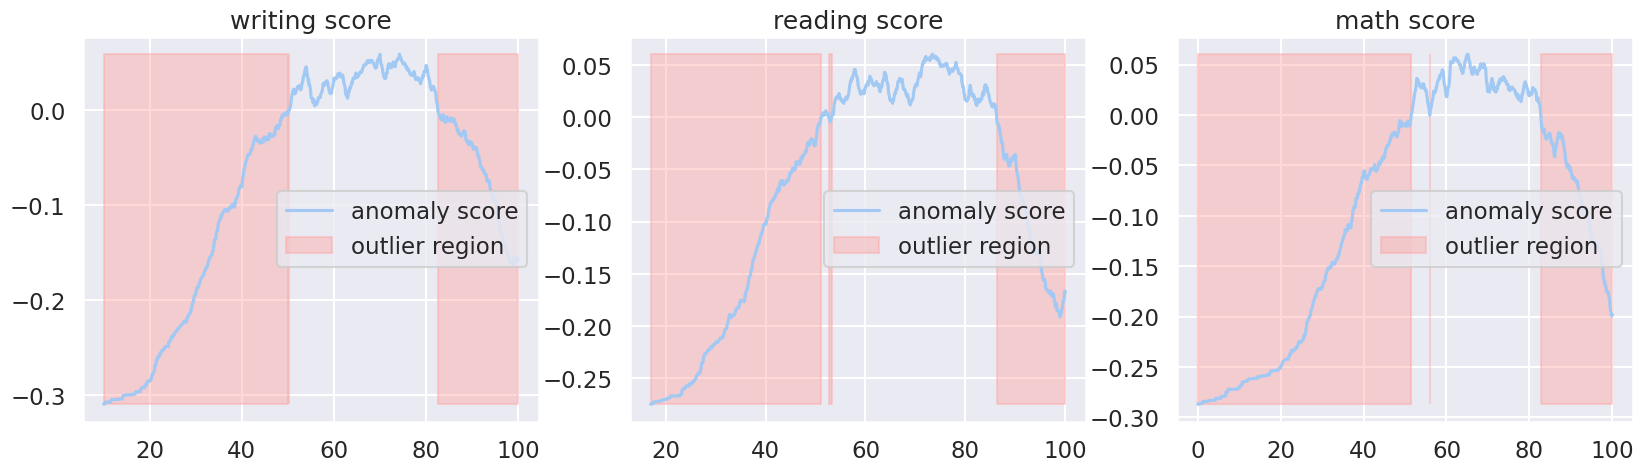

In [37]:
#Importando as bibliotecas 
from sklearn.ensemble import IsolationForest
#Listar as colundas que vamos usar
cols = ['writing score','reading score','math score']
#Plotar 3 gráficos
fig, axs = plt.subplots(1, 3, figsize=(20, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df_2[column].values.reshape(-1,1))

    xx = np.linspace(df_2[column].min(), df_2[column].max(), len(df_2)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

#### No trecho acima, treinamos nosso IsolationForest usando os dados gerados, calculamos a pontuação de anomalia para cada observação e classificamos cada observação como discrepante ou não discrepante.O gráfico mostra as pontuações de anomalia e as regiões onde os valores discrepantes estão. Como esperado, a pontuação da anomalia reflete a forma da distribuição subjacente e as regiões discrepantes correspondem à área de baixa probabilidade.

## B) Outliers multivariados:

# 1) DBSCAN (Density-Based Spatial Clustering of Applications with Noise):

#### Este é um algoritmo de agrupamento (uma alternativa ao K-Means) que agrupa pontos e identifica quaisquer pontos que não pertencem a um agrupamento como valores discrepantes. É como K-means, exceto que o número de clusters não precisa ser especificado antecipadamente.

#### Mostrarei um exemplo de uso do DBScan, mas antes de começarmos, vamos abordar alguns conceitos importantes. DBScan tem três conceitos importantes

#### - Pontos Centrais(Core points): Para entender o conceito dos pontos centrais, precisamos visitar alguns dos hiperparâmetros usados ​​para definir o trabalho DBScan. O primeiro hiperparâmetro (HP) é min_samples.  TEste é simplesmente o número mínimo de pontos centrais necessários para formar um cluster. o segundo HP importante é 'eps'. 'eps' é a distância máxima entre duas amostras para que elas sejam consideradas no mesmo cluster
#### -Os Pontos Fronteiriços(Borders Poins) estão no mesmo cluster que os pontos centrais, mas muito mais distantes do centro do cluster.
#### - Todo o resto é chamado de Noise Points, são pontos de dados que não pertencem a nenhum cluster. Eles podem ser anômalos ou não anômalos e precisam de mais investigação. Agora, vamos ver algum código

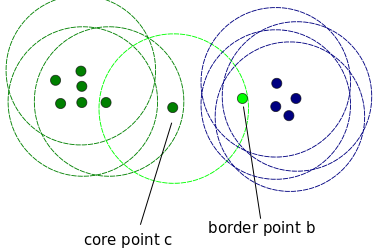

In [31]:
Image(filename=data_dir/'O9.png')

####Considerarei as colunas 'age'(idade) e 'bmi' do conjunto de dados de seguros para avaliação

In [38]:
X = df_3[['age','bmi']].values

db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_

In [39]:
pd.Series(labels).value_counts()

 0    1312
-1      26
Name: count, dtype: int64

### Aqui, os -1 representam os valores discrepantes! 

#### Vamos traçar para diferenciar os outliers. Definirei a cor azul para registros normais e a cor vermelha para valores discrepantes..

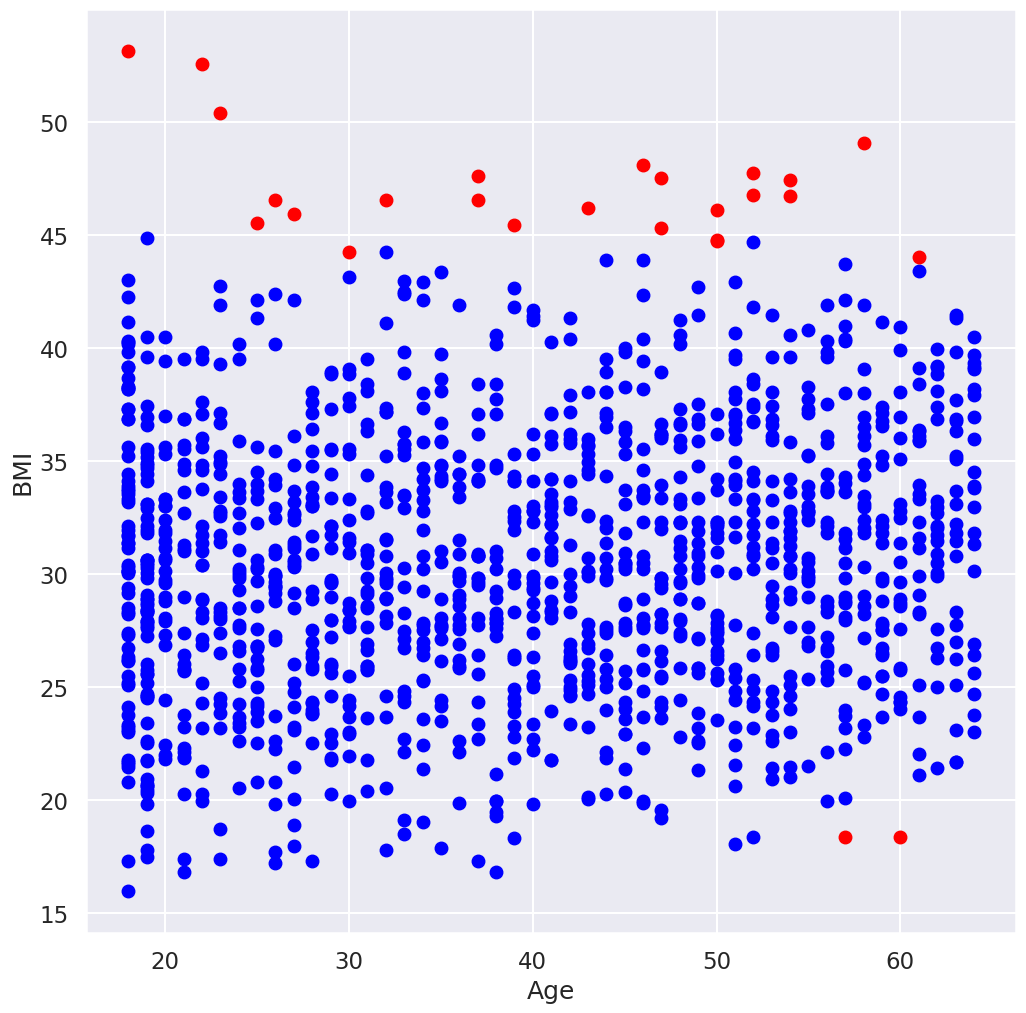

In [40]:
plt.figure(figsize=(12,12))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Age');
plt.ylabel('BMI');

#### A desvantagem deste método é que quanto maior a dimensão, menos preciso ele se torna. Você também precisa fazer algumas suposições, como estimar o valor certo para EPS, o que pode ser desafiador.

# 2) Local Outlier Factor Method(LOF):

#### LOF usa detecção de valores discrepantes com base em densidade para identificar valores discrepantes locais, pontos que são discrepantes em relação à sua vizinhança local, e não em relação à distribuição global de dados. Quanto maior o valor LOF para uma observação, mais anômala será a observação.

#### Isso é útil porque nem todos os métodos identificarão um ponto que é um valor discrepante em relação a um cluster próximo de pontos (um valor discrepante local) se toda essa região não for uma região remota no espaço global de pontos de dados.

#### Um ponto é rotulado como outlier se a densidade em torno desse ponto for significativamente diferente da densidade em torno de seus vizinhos

#### No espaço de recursos abaixo, LOF é capaz de identificar P1 e P2 como valores discrepantes, que são valores discrepantes locais para o Cluster 2 (além de P3).

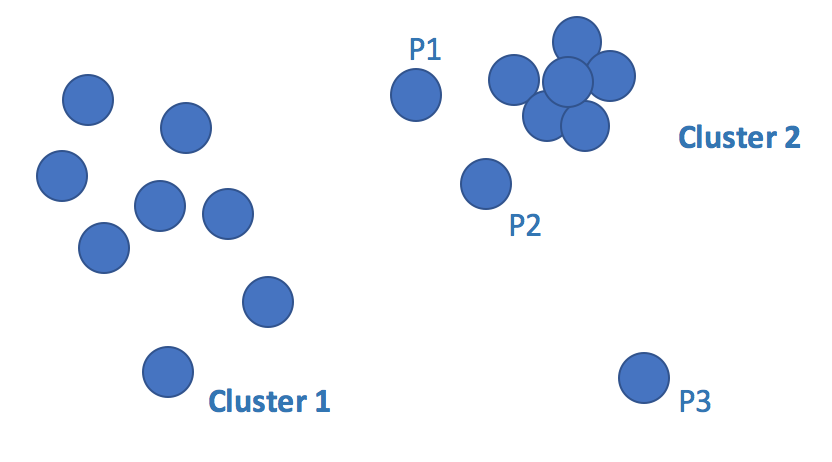

In [35]:
Image(filename=data_dir/'O10.png')

#### Vou considerar a 'age' e o 'chol' do conjunto de dados de doenças cardíacas para a análise multivariada!

In [41]:
clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')
X = df_1[['age','chol']].values
y_pred = clf.fit_predict(X)

#### Agora vamos traçar e visualizar os valores discrepantes. Eu configurei azul para os registros normais e vermelho para valores discrepantes

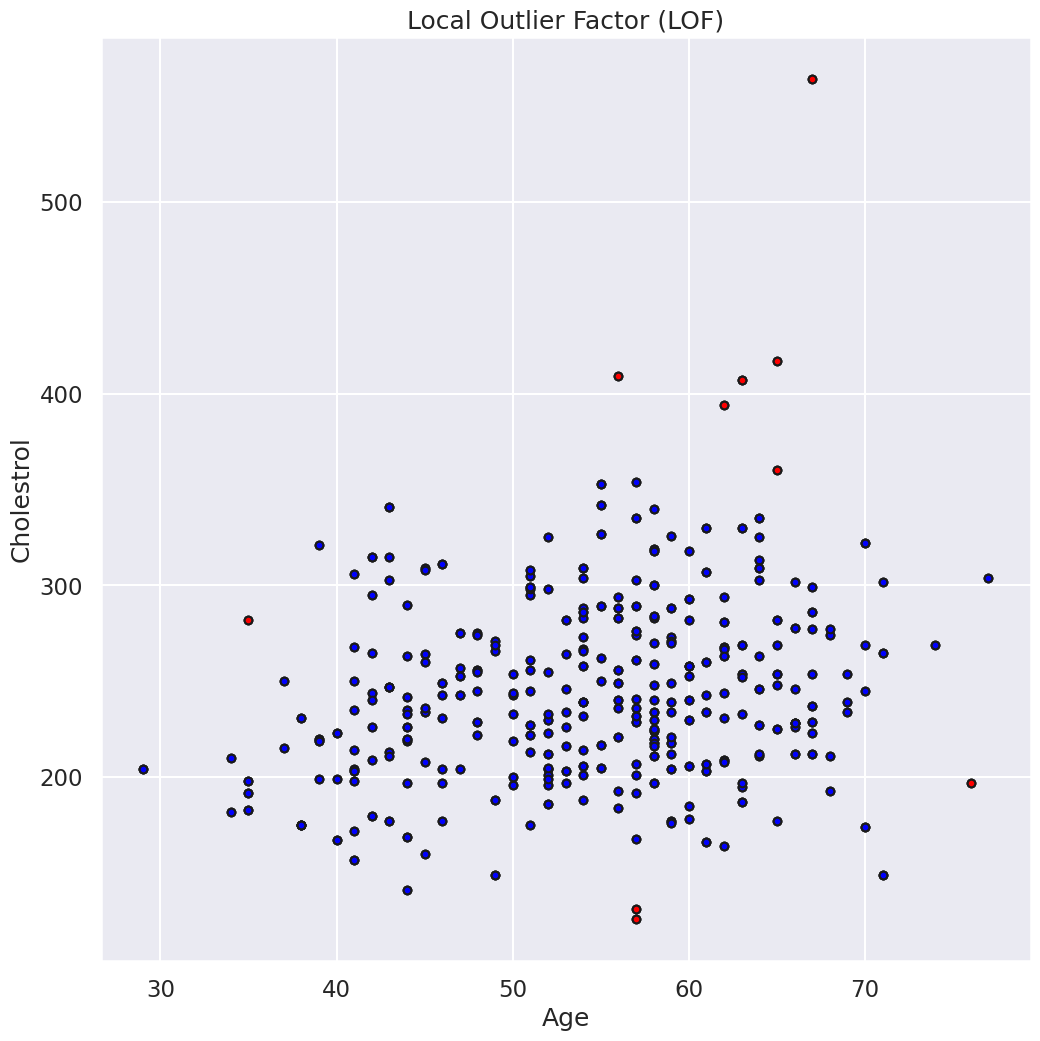

In [43]:
plt.figure(figsize=(12,12))
#traçar os conjuntos de níveis da função de decisão

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
plt.axis('tight')
plt.xlabel('Age');
plt.ylabel('Cholestrol');
plt.show()

## Conclusão:

#### Embora a remoção de valores discrepantes seja uma parte essencial da normalização de um conjunto de dados, é importante garantir zero erros nas suposições que influenciam a remoção de valores discrepantes. Dados com um número ainda significativo de valores discrepantes podem nem sempre ser dados ruins e uma investigação rigorosa do conjunto de dados em si é muitas vezes garantida, mas negligenciada, pelos cientistas de dados em seus processos.

#### Existem alguns processos de detecção de valores discrepantes mais avançados, como:

#### 1) Elliptic Envelope [https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html]
#### 2) One-Class Support Vector Machines [http://rvlasveld.github.io/blog/2013/07/12/introduction-to-one-class-support-vector-machines/]
#### 3) Robust Random Cut Forest [https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/random_cut_forest]

#### Vivemos em um mundo onde os dados aumentam a cada segundo. O valor dos dados pode diminuir com o tempo se não forem usados ​​adequadamente.Encontrar anomalias em um conjunto de dados é crucial para identificar problemas no negócio ou construir uma solução proativa para potencialmente descobrir o problema antes que ele aconteça ou mesmo na fase de análise exploratória de dados (EDA) para preparar um conjunto de dados para ML. 


